# Court Vision Pipeline
### Single Stationary Camera
1. Detect lines or corners of court in a single frame of the clip
2. Compute the homography between the image and the base world frame
3. Make image plane detections. People, Ball etc.
4. Project detections onto base world frame

In [2]:
%load_ext autoreload
%autoreload 2
from pathlib import Path
from torchvision.io import read_image
from courtvision.geometry import (
    get_corners_image,
    get_coords_world_3d_n,
    corners_world_n,
    convert_corners_to_vec,
    PadelCourt,
    compute_homography,
    project_points_to_base_plane
)
from courtvision.geometry import corners_world_3d
import numpy as np
from courtvision.vis import (
    plot_n_images_in_a_grid,
    load_timg,
    plot_3d_lines,
    plot_3d_points,
    log_court_layout
)
from courtvision.swiss import save_camera_params
import cv2
import torch
from torch.nn import functional as F
import matplotlib.pyplot as plt

import rerun as rr

from courtvision.models import get_fasterrcnn_ball_detection_model
from courtvision.swiss import get_latest_file
from courtvision.trackers import ParticleFilter, StateIdx




In [4]:
RUN_PLAYER_DETECTION = True
RUN_BALL_DETECTION = True
RUN_BALL_TRACKER = True

COURT_MESH_PATH = Path(
    "/Users/benjamindecharmoy/projects/courtvision/blender/basic_image.glb"
)

CALIBRATION_FILE = Path(
    "/Users/benjamindecharmoy/projects/courtvision/datasets/calibrations/v1/24_error_11.11_calibration.npz"
)
CLIP_DATA_DIR = Path(
    "/Users/benjamindecharmoy/projects/courtvision/data/frames/curated_001"
)
RAW_CLIP_PATH = Path(
    "/Users/benjamindecharmoy/projects/courtvision/datasets/clip_segmentations/data/0000/output041.mp4"
)
CLIP_NAME = RAW_CLIP_PATH.stem

IMAGE_TO_FLOOR_HOMOGRAPHY_FILE = Path(
    "/Users/benjamindecharmoy/projects/courtvision/data/frames/curated_001/homography.npy"
)

BALL_DETECTOR_DIR = Path(
    "/Users/benjamindecharmoy/projects/courtvision/models/ball_detector/"
)
BALL_DETECTOR_PATH = get_latest_file(BALL_DETECTOR_DIR, ".pt")
BALL_DETECTOR_MODEL_NAME = BALL_DETECTOR_PATH.stem

In [5]:
if RUN_PLAYER_DETECTION:
    from ultralytics import YOLO

    model = YOLO("yolov8n.pt")

    model.classes = [0]
    model.conf = 0.6
    model.max_det = 4
    results = model.track(
        source=RAW_CLIP_PATH.as_posix(),
        # tracker="/Users/benjamindecharmoy/projects/courtvision/bytetrack.yaml",
        tracker="/Users/benjamindecharmoy/projects/courtvision/botsort.yml",
        classes=[0],
        max_det=4,
        save=True,
    )

else:
    from pickle import load, dump

    results = load(open("results.pkl", "rb"))



    WARNING ⚠️ stream/video/webcam/dir predict source will accumulate results in RAM unless `stream=True` is passed,
    causing potential out-of-memory errors for large sources or long-running streams/videos.

    Usage:
        results = model(source=..., stream=True)  # generator of Results objects
        for r in results:
            boxes = r.boxes  # Boxes object for bbox outputs
            masks = r.masks  # Masks object for segment masks outputs
            probs = r.probs  # Class probabilities for classification outputs

video 1/1 (1/2009) /Users/benjamindecharmoy/projects/courtvision/datasets/clip_segmentations/data/0000/output041.mp4: 384x640 3 persons, 38.7ms
video 1/1 (2/2009) /Users/benjamindecharmoy/projects/courtvision/datasets/clip_segmentations/data/0000/output041.mp4: 384x640 3 persons, 37.2ms
video 1/1 (3/2009) /Users/benjamindecharmoy/projects/courtvision/datasets/clip_segmentations/data/0000/output041.mp4: 384x640 3 persons, 36.0ms
video 1/1 (4/2009) /Users/b

In [18]:
# Load Trained Ball detection model
if RUN_BALL_DETECTION:
    ball_detector = get_fasterrcnn_ball_detection_model(BALL_DETECTOR_PATH).eval()

if RUN_BALL_TRACKER:
    rotation_vector = np.load(CALIBRATION_FILE)["rotation_vector"]
    translation_vector = np.load(CALIBRATION_FILE)["translation_vector"]
    rotation_matrix, _ = cv2.Rodrigues(rotation_vector)
    world_to_cam = torch.tensor(
        np.vstack(
            [np.hstack((rotation_matrix, translation_vector)), np.array([0, 0, 0, 1])]
        )
    )
    tracker = ParticleFilter(
        num_particles=1000,
        world_to_cam=world_to_cam,
        cam_to_image=torch.tensor(np.load(CALIBRATION_FILE)["camera_matrix"]),
        court_size=torch.tensor(
            [PadelCourt.width, PadelCourt.length, PadelCourt.backall_fence_height]
        ),
    )

In [19]:
# tracker.state_to_observation(
#     tracker.states, world_to_cam=tracker.world_to_cam, cam_to_image=tracker.cam_to_image
# )

# from courtvision.trackers import StateIdx
# from courtvision.geometry import (
#     convert_points_to_homogeneous,
#     convert_points_from_homogeneous,
# )

# # pred_obs = tracker.state_to_observation(
# #     tracker.states,
# #     world_to_cam=tracker.world_to_cam,
# #     cam_to_image=tracker.cam_to_image
# # )
# # print(pred_obs.shape)
# obs_state=torch.tensor([161, 600]).to(dtype=torch.float32)
# # obs_state = obs_state.expand_as(pred_obs)
# # print(obs_state)
# while True:

#     tracker.predict(dt=1 / 30.0)
#     tracker.update(obs_state=obs_state)
#     print(tracker.mean_image_plane_prediction)
# #  def state_to_observation(state, H):
# # x_y_z_1_positions = convert_points_to_homogeneous(tracker.states[:, : StateIdx.z + 1].rename(None))
# # x_y_z_1_positions_cam = convert_points_from_homogeneous(x_y_z_1_positions @ tracker.world_to_cam.T)
# # # convert_points_from_homogeneous(x_y_z_1_positions_cam@tracker.cam_to_image.T)

# # from kornia.geometry import camera as KCamera
# # KCamera.perspective.project_points(
# #     x_y_z_1_positions_cam, tracker.cam_to_image
# # )
# # # convert_points_from_homogeneous((tracker.H @ x_y_z_1_positions.T).T)


# # tracker.likelihood(obs_state=torch.tensor([100,100]),pred_state=tracker.states)

In [20]:
tracker.xyz

tensor([[-123.7563,  350.3877,   82.6550],
        [ -40.6209,  248.3649,   42.0477],
        [  43.4736,   91.1120,   -1.1429],
        ...,
        [ 181.8639,  206.8106,   12.2311],
        [  16.0311,  221.7910,  -25.1338],
        [  56.2588,  152.0285,    6.3259]], names=('num_particles', 'state'))

In [21]:
from collections import defaultdict
from kornia import image_to_tensor
from datetime import datetime

player_maker_radius = 5.0
base_results = defaultdict(list)
if not RUN_BALL_DETECTION:
    ball_detection_resullt = load(open("ball_detection_resullt.pkl", "rb"))
else:
    ball_detection_resullt = []

if RUN_BALL_TRACKER:
    tracker = ParticleFilter(
        num_particles=1000,
        world_to_cam=world_to_cam,
        cam_to_image=torch.tensor(np.load(CALIBRATION_FILE)["camera_matrix"]),
        court_size=torch.tensor(
            [PadelCourt.width, PadelCourt.length, PadelCourt.backall_fence_height]
        ),
    )


rr.init(
    f"{CLIP_NAME}-{BALL_DETECTOR_MODEL_NAME}-{datetime.now()}", spawn=True
)  # Spawn a Rerun Viewer and stream log events to it

colours_per_idx = defaultdict(lambda: (255, 255, 255))
colours_per_idx.update(
    {
        0: (0, 255, 0),
        1: (0, 0, 255),
        2: (255, 0, 0),
        3: (255, 255, 0),
        4: (255, 0, 255),
        5: (0, 255, 255),
    }
)
rr.set_time_sequence("play", 0)
log_court_layout(
    camera_matrix=np.load(CALIBRATION_FILE)["camera_matrix"],
    image_width=results[0].orig_img.shape[1],
    image_height=results[0].orig_img.shape[0],
    court_mesh_path=COURT_MESH_PATH,
    translation_vector=np.load(CALIBRATION_FILE)["translation_vector"],
    rotation_vector=np.load(CALIBRATION_FILE)["rotation_vector"],
)
H = np.load(IMAGE_TO_FLOOR_HOMOGRAPHY_FILE)

for i, result in enumerate(results):
    # Start streaming results to the Rerun Viewer
    rr.set_time_sequence("play", i)
    if RUN_BALL_DETECTION:
        with torch.no_grad():
            outputs = ball_detector(
                image_to_tensor(result.orig_img, keepdim=False).float() / 255.0,
            )
        ball_detection_resullt.append(outputs)
        dump(ball_detection_resullt, open("ball_detection_resullt.pkl", "wb"))
    else:
        outputs = ball_detection_resullt[i]

    if outputs and len(outputs[0]["boxes"]) > 0:
        for output in outputs:
            for (bx1, by1, bx2, by2), ball_score in zip(
                output["boxes"][:4], output["scores"]
            ):
                # bx1, by1, bx2, by2 = outputs[0]["boxes"][0]
                if bx1 < 200 or bx2 < 200:
                    continue
                rr.log_rect(
                    f"world/camera/image/Ball",
                    (bx1, by1, bx2 - bx1, by2 - by1),
                    color=colours_per_idx[-1],
                )
                # Ball ParticleFilter Goes here!!
                if RUN_BALL_TRACKER:
                    obs_state = torch.tensor(
                        [
                            (bx1 + bx2) / 2.0,
                            (by1 + by2) / 2.0,
                        ]
                    ).to(dtype=torch.float32)
                    xyz = tracker.xyz.clone()
                    xyz[:, StateIdx.y] = 200.0 - xyz[:, StateIdx.y]
                    rr.log_points(
                        "world/ball_state",
                        positions=tracker.xyz,
                    )
                    rr.log_point(
                        "world/tracker_mean",
                        tracker.xyz_mean,
                        color=(255, 222, 0),
                        radius=2.0,
                    )
                    for _ in range(10):
                        tracker.predict(dt=1 / 30.0)
                        tracker.update(obs_state=obs_state, score=ball_score)

                    # Check ParticleFilter and Vis agree on transforms
                    tracker_points = tracker.state_to_observation(
                        tracker.states,
                        world_to_cam=tracker.world_to_cam,
                        cam_to_image=tracker.cam_to_image,
                    )
                    tracker_mean = tracker.state_to_observation(
                        tracker.xyz_mean,
                        world_to_cam=tracker.world_to_cam,
                        cam_to_image=tracker.cam_to_image,
                    )
                    rr.log_points("world/camera/image/tracker", tracker_points)
                    rr.log_point(
                        "world/camera/image/tracker/mean",
                        tracker_mean,
                        radius=10.0,
                        color=(255, 222, 0),
                    )

    rr.log_image("world/camera/image", result.orig_img)

    for det in result.boxes.data:
        x1, y1, x2, y2, idx, conf, cls = det
        rr.log_rect(
            f"world/camera/image/Player_{int(idx)}",
            (x1, y1, (x2 - x1), (y2 - y1)),
            color=colours_per_idx[int(idx)],
        )
        mid_feet = torch.tensor([((x1 + x2) / 2, (y2 + y2) / 2)])
        (mid_feet_base,) = project_points_to_base_plane(points=mid_feet, H=H)

        mid_feet_base_3d = (
            F.pad(mid_feet_base, (0, 1), mode="constant", value=0.0) / 10.0
        )
        # Switch Y and Z axis
        x = mid_feet_base_3d[0].item()
        y = mid_feet_base_3d[1].item()
        z = mid_feet_base_3d[2].item()
        mid_feet_base_3d[2] = player_maker_radius
        mid_feet_base_3d[1] = 200.0 - y
        mid_feet_base_3d[0] = x
        rr.log_point(
            f"world/Player_{int(idx)}",
            mid_feet_base_3d,
            radius=player_maker_radius,
            color=colours_per_idx[int(idx)],
        )

        # base_results[f"{int(idx)}_xs"].append(mid_feet_base[0].item())
        # base_results[f"{int(idx)}_ys"].append(mid_feet_base[1].item())
        # base_results[f"{int(idx)}_zs"].append(0.0)
        # base_results[f"{int(idx)}_conf"].append(conf.item())

    # if i > 10:
    #     break

    # break
# plt.imshow(image)
# results[0].boxes.boxes, results[0].boxes.data

Traceback (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/Users/benjamindecharmoy/projects/courtvision/.venv/lib/python3.11/site-packages/rerun_sdk/rerun/__main__.py", line 16, in <module>
    main()
  File "/Users/benjamindecharmoy/projects/courtvision/.venv/lib/python3.11/site-packages/rerun_sdk/rerun/__main__.py", line 12, in main
    exit(bindings.main(sys.argv))
         ^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: Failed to bind TCP address "0.0.0.0:9876". Another Rerun instance is probably running. Address already in use (os error 48)


In [13]:
np.load(CALIBRATION_FILE)["camera_matrix"]

array([[     1643.1,           0,       633.5],
       [          0,        1673,      310.12],
       [          0,           0,           1]])

In [10]:
ball_detection_resullt[0]

[{'boxes': tensor([[603.8484, 189.4671, 612.9427, 194.0199],
          [131.2941,  79.5147, 144.1550,  90.2277],
          [604.2704, 188.3363, 611.2602, 192.5852],
          [604.0818, 190.9785, 613.0499, 195.5561]]),
  'labels': tensor([1, 1, 1, 1]),
  'scores': tensor([0.9173, 0.3210, 0.3151, 0.2348])}]

In [11]:
results[0].orig_img

array([[[ 40,   6,   0],
        [ 40,   6,   0],
        [ 40,   6,   0],
        ...,
        [  0,   6,  23],
        [  0,   6,  23],
        [  0,   6,  23]],

       [[ 40,   6,   0],
        [ 40,   6,   0],
        [ 40,   6,   0],
        ...,
        [  0,   8,  24],
        [  0,   8,  24],
        [  0,   8,  24]],

       [[ 40,   6,   0],
        [ 40,   6,   0],
        [ 40,   6,   0],
        ...,
        [  1,   9,  25],
        [  1,   9,  25],
        [  1,   9,  25]],

       ...,

       [[105,  81,  53],
        [105,  81,  53],
        [105,  81,  53],
        ...,
        [109,  82,  54],
        [107,  80,  52],
        [105,  79,  51]],

       [[105,  81,  53],
        [105,  81,  53],
        [105,  81,  53],
        ...,
        [109,  82,  54],
        [107,  80,  52],
        [105,  79,  51]],

       [[105,  81,  53],
        [105,  81,  53],
        [105,  81,  53],
        ...,
        [109,  82,  54],
        [107,  80,  52],
        [105,  79,  51]]

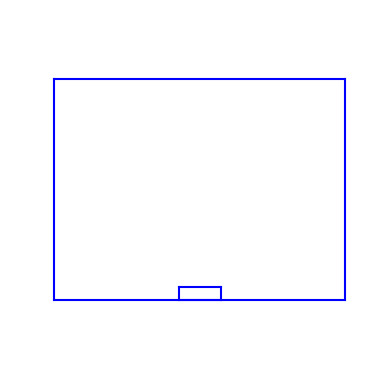

In [12]:
def get_court_frontwall_markings():
    outer_lines = np.array(
        [
            # Outer lines
            corners_world_3d["a_front_left"],
            corners_world_3d["b_front_right"],
            corners_world_3d["n_top_front_right"],
            corners_world_3d["m_top_front_left"],
            corners_world_3d["a_front_left"],
        ],
        dtype=np.float32,
    )
    x_offset = 3 * 100.0
    z_offset = 5 * 100.0
    play_boundary = np.array(
        [
            # Outer lines
            (
                corners_world_3d["a_front_left"][0] - x_offset,
                corners_world_3d["a_front_left"][1],
                corners_world_3d["a_front_left"][2],
            ),
            (
                corners_world_3d["b_front_right"][0] + x_offset,
                corners_world_3d["b_front_right"][1],
                corners_world_3d["b_front_right"][2],
            ),
            (
                corners_world_3d["n_top_front_right"][0] + x_offset,
                corners_world_3d["n_top_front_right"][1],
                corners_world_3d["n_top_front_right"][2] + z_offset,
            ),
            (
                corners_world_3d["m_top_front_left"][0] - x_offset,
                corners_world_3d["m_top_front_left"][1],
                corners_world_3d["m_top_front_left"][2] + z_offset,
            ),
            (
                corners_world_3d["a_front_left"][0] - x_offset,
                corners_world_3d["a_front_left"][1],
                corners_world_3d["a_front_left"][2],
            ),
        ],
        dtype=np.float32,
    )
    xs = np.array([outer_lines[:-1, 0], outer_lines[1:, 0]]).T
    xs = np.append(
        xs, np.array([play_boundary[:-1, 0], play_boundary[1:, 0]]).T, axis=0
    )

    ys = np.array([outer_lines[:-1, 1], outer_lines[1:, 1]]).T
    ys = np.append(
        ys, np.array([play_boundary[:-1, 1], play_boundary[1:, 1]]).T, axis=0
    )

    zs = np.array([outer_lines[:-1, 2], outer_lines[1:, 2]]).T
    zs = np.append(
        zs, np.array([play_boundary[:-1, 2], play_boundary[1:, 2]]).T, axis=0
    )

    return xs, ys, zs


xs, ys, zs = get_court_frontwall_markings()
plt_axis, fig = plot_3d_lines(xs=xs, ys=ys, zs=zs, view_init=(0, 90, 0))
plt_axis.set_title("")
plt_axis.set_xlabel("")
plt_axis.set_ylabel("")
plt_axis.set_xticks([])
plt_axis.set_yticks([])
plt_axis.set_zticks([])
plt_axis.spines["right"].set_visible(False)
plt_axis.spines["top"].set_visible(False)
plt_axis.spines["bottom"].set_visible(False)
plt_axis.spines["left"].set_visible(False)
plt.axis("off")
plt.axis("image")
plt.savefig("frontwall.png", bbox_inches=0)

In [ ]:
corners_world_3d

In [ ]:
def get_court_markings():
    outer_lines = np.array(
        [
            # Outer lines
            corners_world_3d["a_front_left"],
            corners_world_3d["b_front_right"],
            corners_world_3d["d_back_right"],
            corners_world_3d["c_back_left"],
            corners_world_3d["a_front_left"],
        ],
        dtype=np.float32,
    )
    inner_lines = np.array(
        [
            corners_world_3d["e_left_near_serve_line"],
            corners_world_3d["f_right_near_serve_line"],
            corners_world_3d["h_right_far_serve_line"],
            corners_world_3d["g_left_far_serve_line"],
            corners_world_3d["e_left_near_serve_line"],
        ],
        dtype=np.float32,
    )

    center_line = np.array(
        [
            corners_world_3d["k_center_line_near"],
            corners_world_3d["i_center_line_far"],
        ]
    )
    net_line = np.array(
        [
            corners_world_3d["j_net_line_left"],
            corners_world_3d["l_net_line_right"],
        ]
    )

    xs = np.array([outer_lines[:-1, 0], outer_lines[1:, 0]]).T
    xs = np.append(xs, np.array([inner_lines[:-1, 0], inner_lines[1:, 0]]).T, axis=0)
    xs = np.append(xs, np.array([center_line[:-1, 0], center_line[1:, 0]]).T, axis=0)
    xs = np.append(xs, np.array([net_line[:-1, 0], net_line[1:, 0]]).T, axis=0)

    ys = np.array([outer_lines[:-1, 1], outer_lines[1:, 1]]).T
    ys = np.append(ys, np.array([inner_lines[:-1, 1], inner_lines[1:, 1]]).T, axis=0)
    ys = np.append(ys, np.array([center_line[:-1, 1], center_line[1:, 1]]).T, axis=0)
    ys = np.append(ys, np.array([net_line[:-1, 1], net_line[1:, 1]]).T, axis=0)

    zs = np.array([outer_lines[:-1, 2], outer_lines[1:, 2]]).T
    zs = np.append(zs, np.array([inner_lines[:-1, 2], inner_lines[1:, 2]]).T, axis=0)
    zs = np.append(zs, np.array([center_line[:-1, 2], center_line[1:, 2]]).T, axis=0)
    zs = np.append(zs, np.array([net_line[:-1, 2], net_line[1:, 2]]).T, axis=0)

    return xs, ys, zs


xs, ys, zs = get_court_markings()
plt_axis, fig = plot_3d_lines(xs=xs, ys=ys, zs=zs, view_init=(90, 90, 0))
from courtvision.vis import plot_3d_points

idx = 1
# xs = np.array(base_results[f"{idx}_xs"])
# ys = np.array(base_results[f"{idx}_ys"])
# zs = np.array(base_results[f"{idx}_zs"])
plt_axis.set_title("")
plt_axis.set_xlabel("")
plt_axis.set_ylabel("")
plt_axis.set_xticks([])
plt_axis.set_yticks([])
plt_axis.set_zticks([])
plt_axis.spines["right"].set_visible(False)
plt_axis.spines["top"].set_visible(False)
plt_axis.spines["bottom"].set_visible(False)
plt_axis.spines["left"].set_visible(False)
# plot_3d_lines
plt.axis("off")
plt.axis("image")
plt_axis.margins(x=0)
plt.savefig("test.png", bbox_inches=0)

# plt_axis, _=plot_3d_points(x=xs, y=ys, z=zs, plt_axis=plt_axis ,view_init=(90, 90,0))

In [ ]:
rr.log("test", "test")

In [ ]:
from courtvision.vis import plot_3d_points, plot_3d_lines
from courtvision.geometry import get_coords_world_3d
import numpy as np

court_markings = get_coords_world_3d()
xs = np.array([court_markings[:1, 0], court_markings[1:2, 0]]).T
xs = np.append(xs, np.array([court_markings[1:2, 0], court_markings[3:4, 0]]).T, axis=0)
xs = np.append(xs, np.array([court_markings[3:4, 0], court_markings[4:5, 0]]).T, axis=0)
xs = np.append(xs, np.array([court_markings[4:5, 0], court_markings[:1, 0]]).T, axis=0)

ys = np.array([court_markings[:-1, 1], court_markings[1:, 1]]).T
zs = np.array([court_markings[:-1, 2], court_markings[1:, 2]]).T
plot_3d_lines(xs=xs, ys=ys, zs=zs)
# get_coords_world_3d()